## Task II: Classical Graph Neural Network (GNN) 

For Task II, you will use ParticleNet's data for Quark/Gluon jet classification with its corresponding description.

## Data Preparation

In [1]:
import numpy as np
import pandas as pd


In [2]:
!wget -qq "https://zenodo.org/record/3164691/files/QG_jets.npz"

#temp = np.load('QG_jets.npz')
print(temp.files)


['X', 'y']


In [3]:
x = temp['X']
y = temp['y']

print(x.shape, y.shape)

(100000, 139, 4) (100000,)


array([[<Axes: title={'center': '0'}>]], dtype=object)

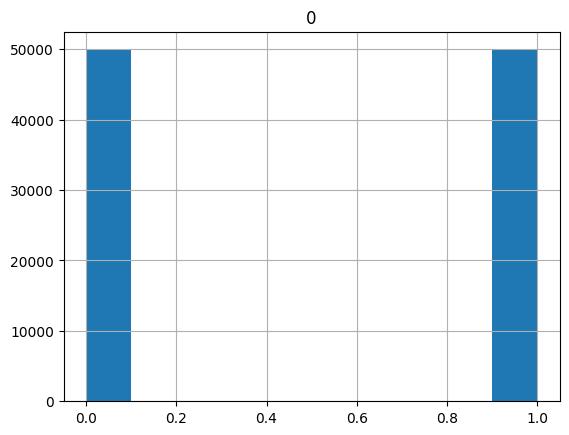

In [4]:
y = pd.DataFrame(temp['y'])
y.hist()

In [5]:
X=[]
for i in temp["X"]:
    X.append(i[0])
X=pd.DataFrame(X,columns=["pt","eta","azimuthal","pgdid"])
y=pd.DataFrame(temp["y"],columns=["Y"])
X["y"]=y

X.head()

,pt,eta,azimuthal,pgdid,y
0,0.268769,0.356903,4.741387,22.0,1.0
1,1.212663,-0.112853,3.047088,-211.0,1.0
2,0.216829,-0.997057,0.532569,22.0,1.0
3,0.413806,0.956889,5.742566,211.0,1.0
4,0.476434,-0.403307,4.126747,22.0,1.0


<Axes: >

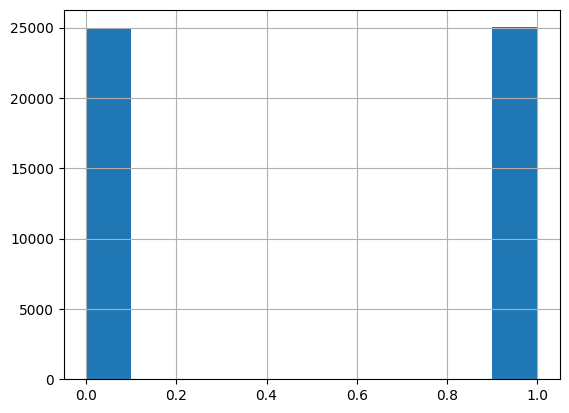

In [6]:
X = X[:50000]
y=X["y"]
X=X.drop(["y"],axis=1)
y.hist()

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)
print(len(X_train))

32500


## DGL

In [8]:
import dgl
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import networkx as nx

/Users/amiruladlilhakim/Documents/VirtualEnv/pennylane_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
def build_graph(edges):
    g = dgl.DGLGraph()
    g.add_nodes(len(X))
    src, dst = tuple(zip(*edges))
    g.add_edges(src, dst)
    g.add_edges(dst, src)
    return g

In [10]:
edge_list=[]
from itertools import combinations  

import random
edges=random.sample(range(1, len(X_train)), int(len(X_train)/30))
edge_list=combinations(edges,2)

In [11]:
edge_list=list(edge_list)
print(len(edge_list))


585903


In [12]:
G = build_graph(edge_list)


/Users/amiruladlilhakim/Documents/VirtualEnv/pennylane_venv/lib/python3.12/site-packages/dgl/heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


In [13]:
print('Number of nodes: %d ' % G.number_of_nodes())
print('Number of edges: %d ' % G.number_of_edges())

Number of nodes: 50000 
Number of edges: 1171806 


In [14]:
import torch.nn as nn
import torch.nn.functional as F
def gcn_message(edges):
    return {'msg' : edges.src['h']}

def gcn_reduce(nodes):
    return {'h' : torch.sum(nodes.mailbox['msg'], dim=1)}

# GCNLayer module
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)

    def forward(self, g, inputs):
        g.ndata['h'] = inputs
        g.send_and_recv(g.edges(), gcn_message, gcn_reduce)
        h = g.ndata.pop('h')
        return self.linear(h)

In [15]:
class GCN(nn.Module):
    def __init__(self, in_feats, hidden_size, num_classes):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(in_feats, hidden_size)
        self.gcn2 = GCNLayer(hidden_size, num_classes)
        self.softmax = nn.Softmax()

    def forward(self, g, inputs):
        h = self.gcn1(g, inputs)
        h = torch.relu(h)
        h = self.gcn2(g, h)
        h = self.softmax(h)
        return h
net = GCN(4, 10, 2)

In [16]:
inputs = torch.tensor(X.values)
labeled_nodes = torch.tensor(y_train[::3].index)
labels = torch.tensor(y_train[::3].values)  

In [17]:
print(max(y_train[::3].keys()),len(labels))


49998 10834


In [18]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
all_preds = []
epochs = 150
losses=[]
for epoch in range(epochs):
    preds = net(G, inputs.float())
    all_preds.append(preds)

    print(len(preds),len(labels))
    loss = F.cross_entropy(preds[labeled_nodes], labels.long())
    losses.append(loss)
    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step()

    print('Epoch %d | Loss: %.4f' % (epoch, loss.item()))

/Users/amiruladlilhakim/Documents/VirtualEnv/pennylane_venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


50000 10834
Epoch 0 | Loss: 0.7813
50000 10834
Epoch 1 | Loss: 0.7808
50000 10834
Epoch 2 | Loss: 0.7804
50000 10834
Epoch 3 | Loss: 0.7799
50000 10834
Epoch 4 | Loss: 0.7794
50000 10834
Epoch 5 | Loss: 0.7789
50000 10834
Epoch 6 | Loss: 0.7784
50000 10834
Epoch 7 | Loss: 0.7779
50000 10834
Epoch 8 | Loss: 0.7775
50000 10834
Epoch 9 | Loss: 0.7770
50000 10834
Epoch 10 | Loss: 0.7765
50000 10834
Epoch 11 | Loss: 0.7760
50000 10834
Epoch 12 | Loss: 0.7756
50000 10834
Epoch 13 | Loss: 0.7751
50000 10834
Epoch 14 | Loss: 0.7746
50000 10834
Epoch 15 | Loss: 0.7742
50000 10834
Epoch 16 | Loss: 0.7737
50000 10834
Epoch 17 | Loss: 0.7732
50000 10834
Epoch 18 | Loss: 0.7728
50000 10834
Epoch 19 | Loss: 0.7723
50000 10834
Epoch 20 | Loss: 0.7719
50000 10834
Epoch 21 | Loss: 0.7714
50000 10834
Epoch 22 | Loss: 0.7710
50000 10834
Epoch 23 | Loss: 0.7705
50000 10834
Epoch 24 | Loss: 0.7701
50000 10834
Epoch 25 | Loss: 0.7697
50000 10834
Epoch 26 | Loss: 0.7692
50000 10834
Epoch 27 | Loss: 0.7688
50

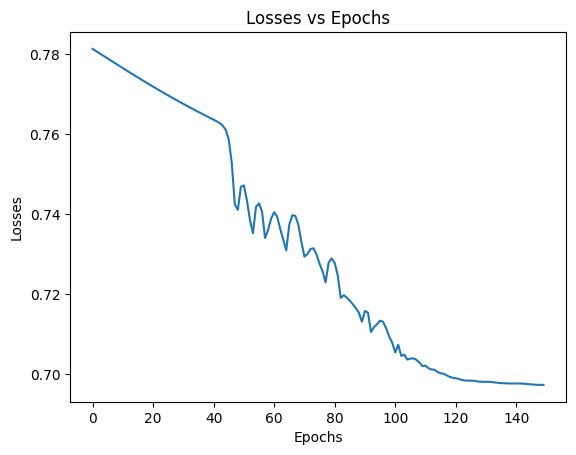

In [19]:
import matplotlib.pyplot as plt

losses_list = []
for i in losses:
    losses_list.append(i.item())

plt.plot(range(epochs),losses_list)
plt.title('Losses vs Epochs')
plt.ylabel('Losses')
plt.xlabel('Epochs')

plt.show()

In [20]:
last_epoch = all_preds[epochs-1].detach().numpy()
predicted_class = np.argmax(last_epoch, axis=-1)

from sklearn.metrics import accuracy_score
accuracy_score(predicted_class,y)

0.50216

## Reference

Tale, Mihir. "GNN for Jet Identification." 2020. GitHub, https://github.com/mstale007/GNN_for_Jet_Identification. Accessed 2 April 2024.
